In [1]:
#Libraries import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import RocCurveDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import joblib

Data Ingestion

In [77]:
df=pd.read_csv('./data/data.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [74]:
#Data schema
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
len(df['customerID'].unique())

7043

Each data as unique customerID, witch is not nessesary for data modelisation, let's remove them

In [78]:
df.shape

(7043, 21)

In [79]:
df.drop('customerID',axis=1,inplace=True)

In [80]:
df.shape

(7043, 20)

In [6]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
df['Churn'].value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

The classes that we want to predict are not equally distributed, so we should use an algorithm that can handle that.

In [8]:
#Transform a predict variable in to numerical binarie

df['Churn']=df['Churn'].apply(lambda val: 0 if val=='No' else 1)
df['Churn'].head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

In [9]:
df['Churn'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

In [10]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                 int64
dtype: object

In [11]:
df.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [12]:
#Data splitting into training, validation, and test datasets
seed=123
train,test=train_test_split(df,test_size=0.3,random_state=seed,stratify=df['Churn'])
test,validate=train_test_split(test,test_size=0.5,random_state=seed,stratify=test['Churn'])

print("train data",train.shape)
print("validation data",train.shape)
print("test data",test.shape)


train data (4930, 20)
validation data (4930, 20)
test data (1056, 20)


In [13]:
train['Churn'].value_counts(normalize=True)

0    0.734686
1    0.265314
Name: Churn, dtype: float64

In [14]:
test['Churn'].value_counts(normalize=True)

0    0.734848
1    0.265152
Name: Churn, dtype: float64

In [15]:
validate['Churn'].value_counts(normalize=True)

0    0.734153
1    0.265847
Name: Churn, dtype: float64

In [16]:
#Saving the different data sets
train.to_csv('./data/train.csv',index=False)
test.to_csv('./data/test.csv',index=False)
validate.to_csv('./data/validate.csv',index=False)

# Exploratory Analysis

In [17]:
train_copy=train.copy()

In [18]:
train_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,4930.0,0.155781,0.362684,0.00,0.00,0.0,0.0000,1.00
tenure,4930.0,32.207911,24.628948,0.00,8.00,29.0,55.0000,72.00
MonthlyCharges,4930.0,64.684189,29.962114,18.55,35.75,70.3,89.6875,118.75
Churn,4930.0,0.265314,0.441545,0.00,0.00,0.0,1.0000,1.00


In [19]:
#Categorical Features
cat_cols=train_copy.select_dtypes(include='object').columns.to_list()
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'TotalCharges']

In [20]:
#Numericals Features
num_cols=train_copy.select_dtypes(exclude='object').columns.to_list()
num_cols

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Churn']

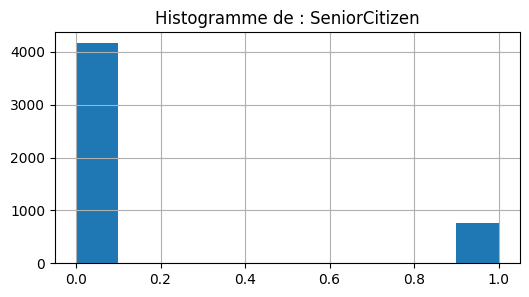

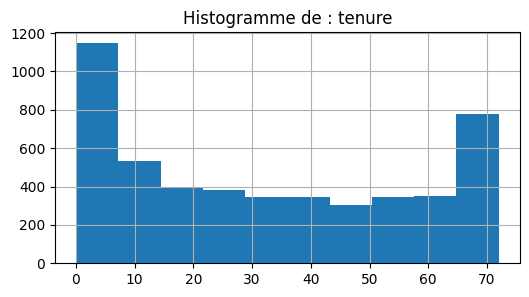

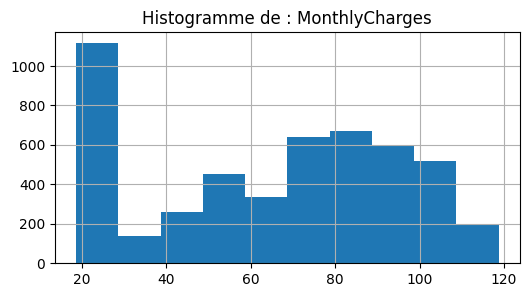

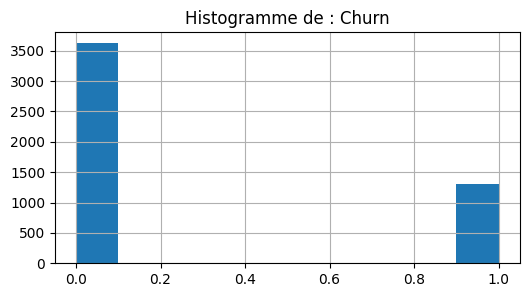

In [21]:
# Histograms for numericals features
for col in num_cols :
    plt.figure(figsize=(6,3))
    train_copy[col].hist()
    plt.title(f"Histogramme de : {col}")
    plt.show()
    plt.close()

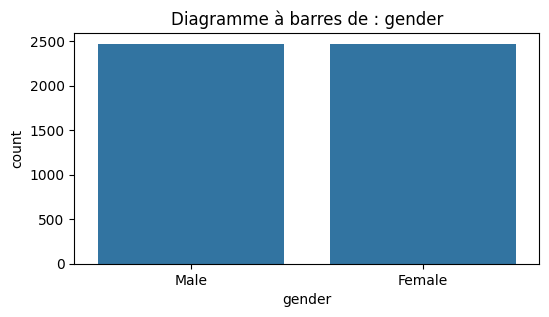

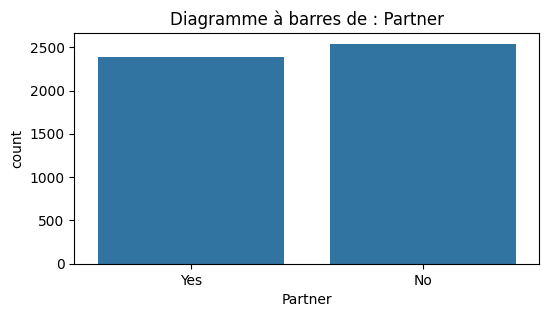

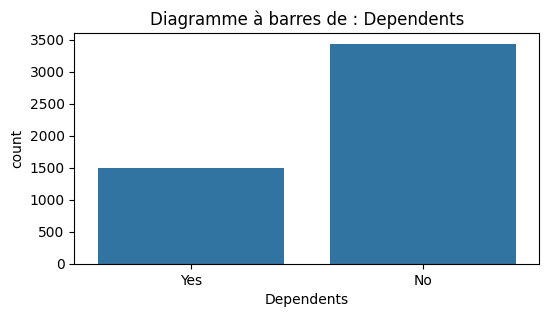

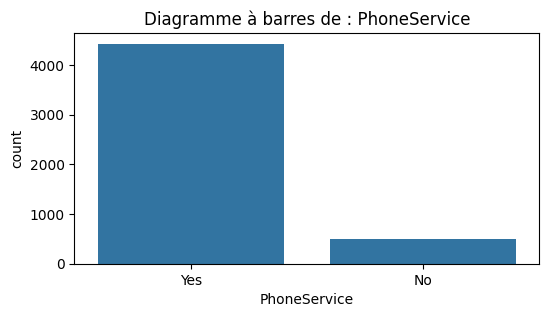

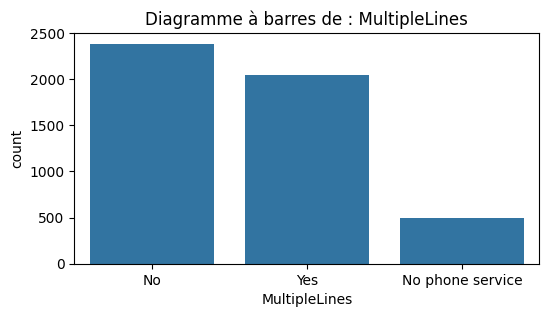

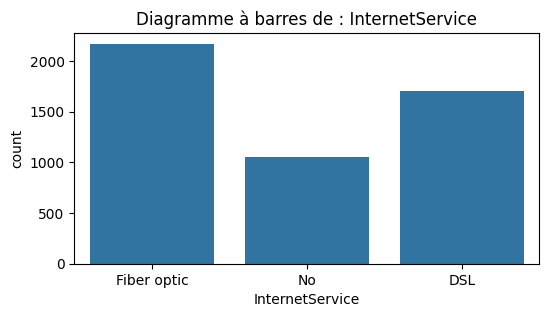

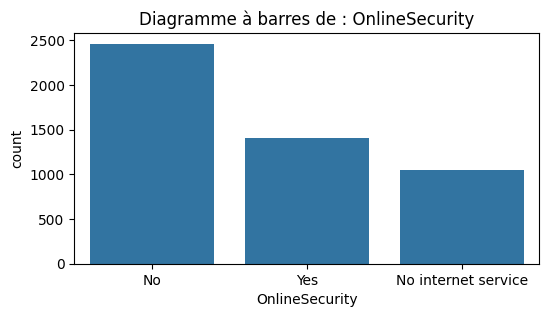

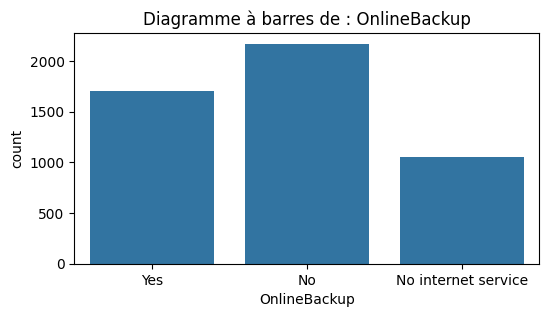

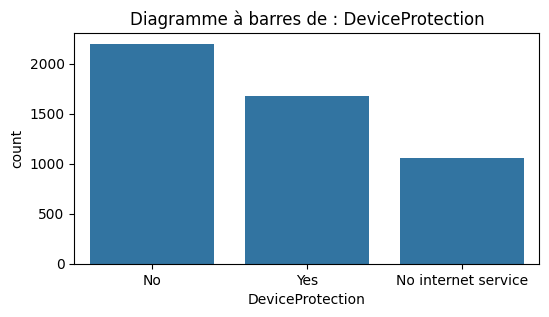

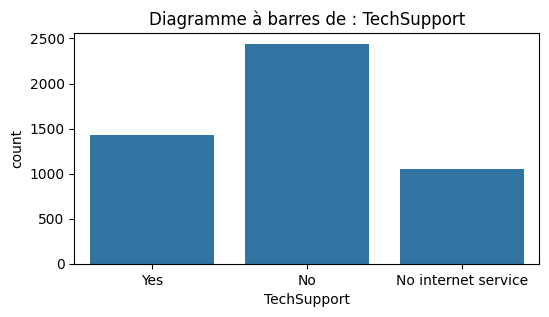

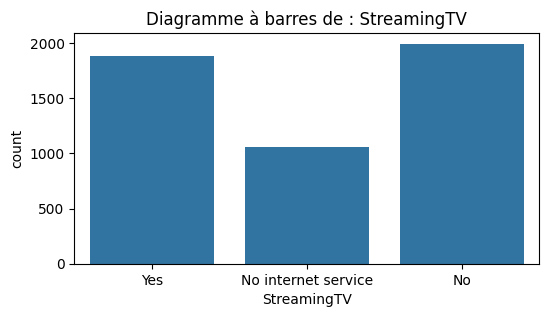

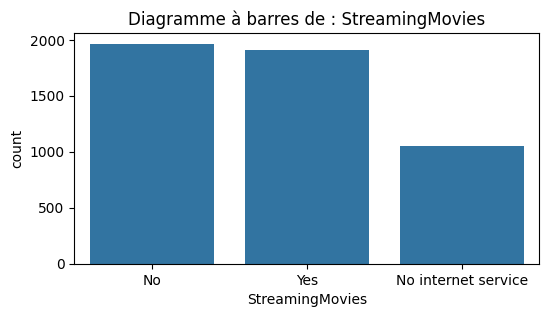

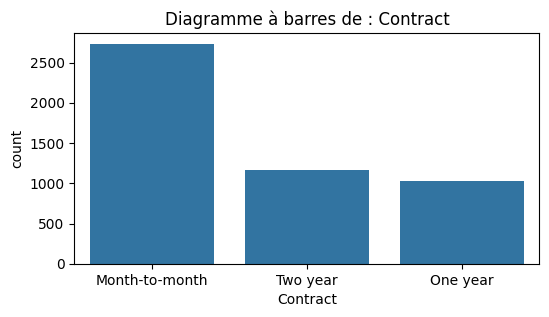

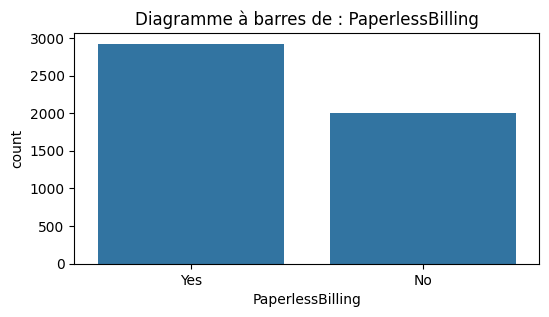

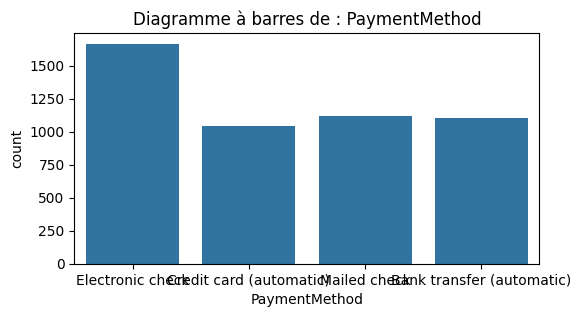

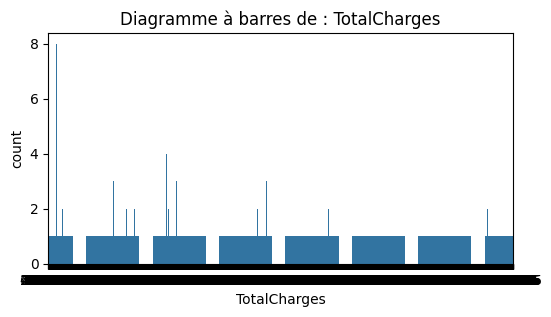

In [22]:
#Bar charts for categorical features
for col in cat_cols :
    plt.figure(figsize=(6,3))
    sns.countplot(data=train_copy,x=col)
    plt.title(f"Diagramme à barres de : {col}")
    plt.show()
    plt.close()

In [23]:
train_copy['TotalCharges']

4890    4779.45
511     6300.15
169       321.4
3649    1847.55
1568    1183.05
         ...   
3194     2342.2
4935    1174.35
6883     3688.6
2711    2598.95
5298    6401.25
Name: TotalCharges, Length: 4930, dtype: object

Pandas consider TotalCharges features as object or categorical features

In [27]:
#Correlation matrix
train_corr=train_copy.corr()
train_corr

,SeniorCitizen,tenure,MonthlyCharges,Churn
SeniorCitizen,1.000000,0.006503,0.224643,0.163730
tenure,0.006503,1.000000,0.241675,-0.354819
MonthlyCharges,0.224643,0.241675,1.000000,0.193961
Churn,0.163730,-0.354819,0.193961,1.000000


<AxesSubplot:>

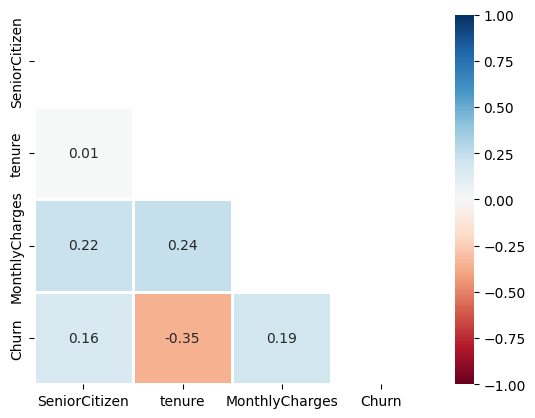

In [34]:
sns.heatmap(
    train_corr,
    mask=np.triu(np.ones_like(train_corr,dtype=bool)),
    center=0,cmap='RdBu', linewidths=1,annot=True, fmt=".2f",
    vmin=-1,vmax=1
    
    
)

# Data Préprocessing

In [35]:
#Convert 'TotalCharges' columns to numérical columns 
total_charges=pd.to_numeric(train_copy['TotalCharges'], errors='coerce')
total_charges.isna().sum()

8

In [39]:
#Display no-numérical values of 'TotalCharges'
train_copy[total_charges.isna()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6754,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,0
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0


In [40]:
#Display indexces of
train_copy[total_charges.isna()]['TotalCharges']

6754     
488      
5218     
1082     
1340     
4380     
6670     
753      
Name: TotalCharges, dtype: object

In [41]:
train_copy[total_charges.isna()]['TotalCharges'].unique()

array([' '], dtype=object)

We have some spaces ' ' as values in the TotalCharges comums
Let's create a pipeline to preporcess the data

In [47]:
#Function to covert TotalCharges columns to numérical
def convert_totalcharges(X):
    #X: dataframe
    Z=X.copy()
    Z['TotalCharges']=pd.to_numeric(Z['TotalCharges'],errors='coerce')
    return Z.values #return a numpy arrays

Let's create a list of categorical features and a list of numericals features

In [42]:
num_cols

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Churn']

In [43]:
numeric_features=num_cols[:-1]+['TotalCharges']
numeric_features

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [44]:
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'TotalCharges']

In [45]:
categorical_features=cat_cols[:-1]
categorical_features

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [54]:
#Pipeline for numeric variables processing
numeric_transformer=Pipeline(
    steps=[('convert',FunctionTransformer(convert_totalcharges)),
           ('imputer',SimpleImputer(strategy='median')),
           ('scaler',StandardScaler())]
)

#Pipeline categorical variables processing
categorical_transformer=Pipeline(
    steps=[('Onehotencoder',OneHotEncoder(sparse=False,handle_unknown='ignore'))]
)

#Data prepocessing pipeline
preprocessor=ColumnTransformer(
    transformers=[('numeric',numeric_transformer,numeric_features),
                  ('categorical',categorical_transformer,categorical_features)]
)

print(preprocessor)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('convert',
                                                  FunctionTransformer(func=<function convert_totalcharges at 0x000001534C9A8280>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['SeniorCitizen', 'tenure', 'MonthlyCharges',
                                  'TotalCharges']),
                                ('categorical',
                                 Pipeline(steps=[('Onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['gender', 'Partner', 'Dependents',
                                  'PhoneService', 

In [55]:
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('convert',
                                                  FunctionTransformer(func=<function convert_totalcharges at 0x000001534C9A8280>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['SeniorCitizen', 'tenure', 'MonthlyCharges',
                                  'TotalCharges']),
                                ('categorical',
                                 Pipeline(steps=[('Onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['gender', 'Partner', 'Dependents',
                                  'PhoneService', 'MultipleLines',
                                  'InternetService', 'OnlineSecurity',
                                  'OnlineBackup', 'DeviceProtection',
                                  'TechSupport', 'StreamingTV',
                                  'StreamingMovies', 'Contract',
                                  'PaperlessBilling', 'PaymentMethod'])])

# Modalisation

In [56]:
#Data modélisation pipeline with random forest algorith

rf_pipe_model=Pipeline(
    steps=[('preprocessor',preprocessor),
           ('rf',RandomForestClassifier(random_state=seed))]
)
rf_pipe_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('convert',
                                                                   FunctionTransformer(func=<function convert_totalcharges at 0x000001534C9A8280>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categorical',
                                                  Pipeline(steps=[('Onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('rf', RandomForestClassifier(random_state=123))])

In [57]:
#Data modélisation pipeline with Logistic Regression algorith

logreg_pipe_model=Pipeline(
    steps=[('preprocessor',preprocessor),
           ('logreg',LogisticRegression(random_state=seed))]
)
logreg_pipe_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('convert',
                                                                   FunctionTransformer(func=<function convert_totalcharges at 0x000001534C9A8280>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categorical',
                                                  Pipeline(steps=[('Onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('rf', LogisticRegression(random_state=123))])

In [81]:
train.shape

(4930, 20)

In [86]:
X_train=train.drop('Churn',axis=1)
X_val=validate.drop('Churn',axis=1)

y_train=train['Churn']
y_val=validate['Churn']

print(X_train.shape,y_train.shape,X_val.shape, y_val.shape)


(4930, 19) (4930,) (1057, 19) (1057,)


c:\Users\ODJO\anaconda3\envs\gdal\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3622
           1       1.00      1.00      1.00      1308

    accuracy                           1.00      4930
   macro avg       1.00      1.00      1.00      4930
weighted avg       1.00      1.00      1.00      4930



              precision    recall  f1-score   support

           0       0.81      0.89      0.85       776
           1       0.59      0.43      0.50       281

    accuracy                           0.77      1057
   macro avg       0.70      0.66      0.67      1057
weighted avg       0.75      0.77      0.76      1057



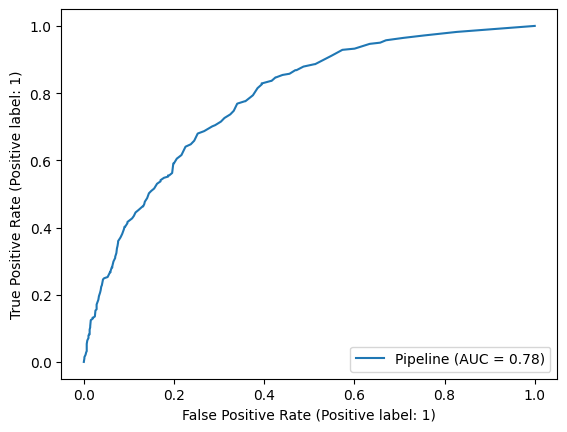

In [90]:
#Ramdom forest model training
rf_pipe_model.fit(X_train,y_train)

#Prediction on training data
y_train_pred_rf=rf_pipe_model.predict(X_train)

#Prediction on validation data
y_val_pred_rf=rf_pipe_model.predict(X_val)


#Classification report
print(classification_report(y_train,y_train_pred_rf))
print('\n')
print(classification_report(y_val,y_val_pred_rf))

# ROC curve

rf_roc=RocCurveDisplay.from_estimator(rf_pipe_model, X_val,y_val)

c:\Users\ODJO\anaconda3\envs\gdal\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.85      0.90      0.87      3622
           1       0.66      0.55      0.60      1308

    accuracy                           0.80      4930
   macro avg       0.75      0.72      0.74      4930
weighted avg       0.80      0.80      0.80      4930



              precision    recall  f1-score   support

           0       0.83      0.89      0.86       776
           1       0.62      0.48      0.54       281

    accuracy                           0.78      1057
   macro avg       0.72      0.69      0.70      1057
weighted avg       0.77      0.78      0.77      1057



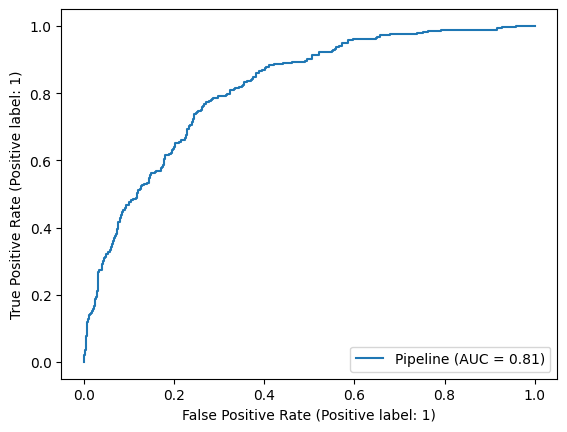

In [91]:
#Logistic Regression model training
logreg_pipe_model.fit(X_train,y_train)

#Prediction on training data
y_train_pred_lg=logreg_pipe_model.predict(X_train)

#Prediction on validation data
y_val_pred_lg=logreg_pipe_model.predict(X_val)


#Classification report
print(classification_report(y_train,y_train_pred_lg))
print('\n')
print(classification_report(y_val,y_val_pred_lg))

# ROC curve

rf_roc=RocCurveDisplay.from_estimator(logreg_pipe_model, X_val,y_val)

Logistic regression is the best model

# Hyperprameters turning

In [93]:
#Data modélisation pipeline with Logistic Regression algorith

model_pipeline=Pipeline(
    steps=[('preprocessor',preprocessor),
           ('logreg',LogisticRegression(random_state=seed))]
)
param_grid={
    'logreg__solver' : ['lbfgs','saga','sag','newton-cg','newton-cholesky'],
    'logreg__penalty' : ['l2',None],
    'logreg__C' : [0.5,1.0,5.0,10]
}

search_model=GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

search_model.fit(X_train,y_train)
print(search_model.best_params_)
print(search_model.best_score_)

{'logreg__C': 5.0, 'logreg__penalty': 'l2', 'logreg__solver': 'newton-cg'}
0.8443050118043238


c:\Users\ODJO\anaconda3\envs\gdal\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [95]:
#model saving
joblib.dump(search_model.best_estimator_,'./models/best_model.pkl')


['./models/best_model.pkl']

Analyse best model performance on test data set

In [96]:
# Load mdoel
loaded_model=joblib.load('./models/best_model.pkl')
loaded_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('convert',
                                                                   FunctionTransformer(func=<function convert_totalcharges at 0x000001534C9A8280>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('categorical',
                                                  Pipeline(steps=[('On...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('logreg',
                 LogisticRegression(C=5.0, random_state=123,
                                    solver='newton-cg'))])

In [97]:
# Prédiction on test data
X_test=test.drop('Churn', axis=1)
y_test= test['Churn']

y_test_pred=loaded_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       776
           1       0.71      0.59      0.64       280

    accuracy                           0.83      1056
   macro avg       0.78      0.75      0.76      1056
weighted avg       0.82      0.83      0.82      1056



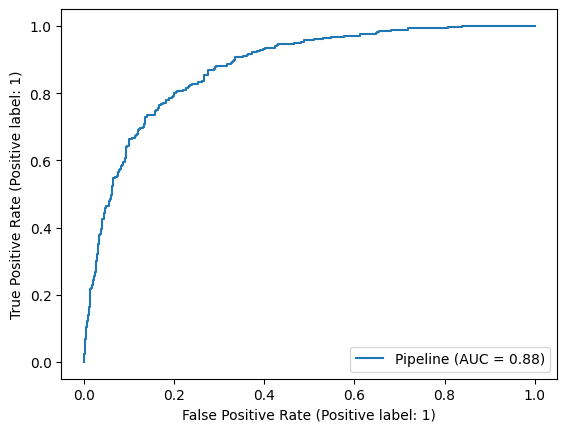

In [100]:
#Classification reprort
print(classification_report(y_test,y_test_pred))

#courbe ROC
roc_plot=RocCurveDisplay.from_estimator(loaded_model,X_test,y_test)